# 3.3 Pythonによる分析の準備

In [1]:
# ライブラリ
import numpy as np
import pandas as pd
pd.set_option("display.unicode.east_asian_width", True)
pd.set_option("display.precision", 3)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install japanize-matplotlib
import japanize_matplotlib
japanize_matplotlib.japanize()

     |████████████████████████████████| 4.1 MB 3.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=06abd7d09b1d8df1ca1a8f29ac281cbfe50b91240cf574b0880934d17ae28477
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


# 3.4 利得行列の作成

In [2]:
# 気温からつぼみ損失率を計算する関数
def calc_bud_loss_ratio(temperature, beta_0 = -2, beta_1 = -1.5):
  return 1 / (1 + np.exp(-(beta_0 + beta_1 * temperature)))

In [3]:
# つぼみ損失率から収穫損失率を計算する関数
def calc_yield_loss_ratio(bud_loss_ratio, threshold = 0.5):
  ret = np.where(bud_loss_ratio >= threshold, ((bud_loss_ratio - threshold) / (1 - threshold)) ** 2, 0)
  return ret

Text(0, 0.5, '収穫損失率')

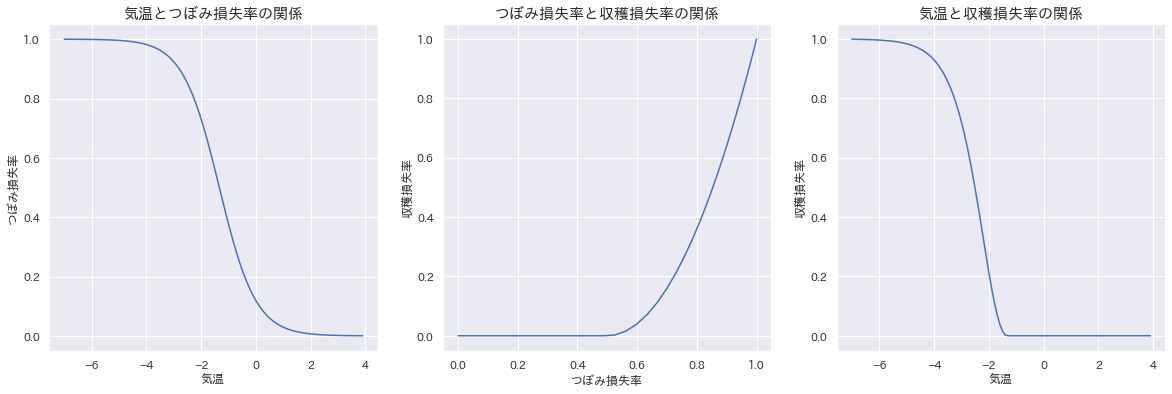

In [4]:
# 可視化
fig, [ax1, ax2, ax3] = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 6))

# 気温とつぼみ損失率の関係
temperature = np.arange(-7, 4, 0.1)
bud_loss_ratio = calc_bud_loss_ratio(temperature)
ax1.plot(temperature, bud_loss_ratio)
ax1.set_title("気温とつぼみ損失率の関係", fontsize = 15)
ax1.set_xlabel("気温")
ax1.set_ylabel("つぼみ損失率")

# つぼみ損失率と収益損失率の関係
yield_loss_ratio = calc_yield_loss_ratio(bud_loss_ratio)
ax2.plot(bud_loss_ratio, yield_loss_ratio)
ax2.set_title("つぼみ損失率と収穫損失率の関係", fontsize = 15)
ax2.set_xlabel("つぼみ損失率")
ax2.set_ylabel("収穫損失率")

# 気温と収穫損失率の関係
ax3.plot(temperature, yield_loss_ratio)
ax3.set_title("気温と収穫損失率の関係", fontsize = 15)
ax3.set_xlabel("気温")
ax3.set_ylabel("収穫損失率")

## 3.4.4 気温別・対策の有無別の収益

In [5]:
# 設定
temperature = np.arange(-7, 5, 1)
T = 200
C = 20
temp_delta = 3

# つぼみ損失率
bud_loss_ratio_1 = calc_bud_loss_ratio(temperature)
bud_loss_ratio_2 = calc_bud_loss_ratio(temperature + temp_delta)

# 収穫率
yield_ratio_1 = 1 - calc_yield_loss_ratio(bud_loss_ratio_1)
yield_ratio_2 = 1 - calc_yield_loss_ratio(bud_loss_ratio_2)

# 利得
return_1 = yield_ratio_1 * T
return_2 = yield_ratio_2 * T - C

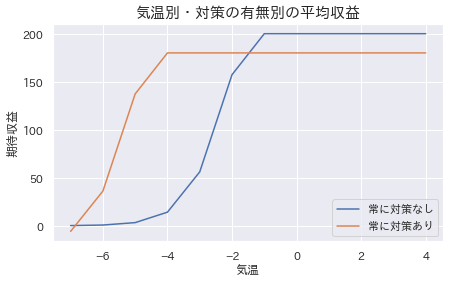

In [6]:
# 可視化
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(temperature, return_1, label = "常に対策なし")
ax.plot(temperature, return_2, label = "常に対策あり")
ax.set_title("気温別・対策の有無別の平均収益", fontsize = 15)
ax.set_xlabel("気温")
ax.set_ylabel("期待収益")
ax.legend(loc = "best")

## 3.4.5 利得行列の作成

In [20]:
payoff = pd.DataFrame({
    "対策なし": return_1, 
    "対策あり": return_2
})
index_name = np.char.add(temperature.astype("str"), "度")
payoff.index = index_name
payoff

,対策なし,対策あり
-7度,0.163,-5.870
-6度,0.728,36.083
-5度,3.243,137.290
-4度,14.130,180.000
-3度,56.083,180.000
-2度,157.290,180.000
-1度,200.000,180.000
0度,200.000,180.000
1度,200.000,180.000
2度,200.000,180.000


# 3.5 数量予測の尺度指向アプローチに基づく評価

In [8]:
# CSVファイルの読み込み
a_f = pd.read_csv('https://raw.githubusercontent.com/logics-of-blue/book-decision-analysis-and-forecast/main/book-data/3-3-sample-forecast-result.csv', index_col = 0)
a_f.head()

,actual,forecast
0,0.4,0.3
1,-2.9,-4.6
2,-2.8,-2.4
3,-3.6,-3.8
4,-0.7,-1.8


In [9]:
# 予測の評価指標
print(f"MAE: {mean_absolute_error(a_f.actual, a_f.forecast):.3g}")
print(f"RMSE: {np.sqrt(mean_squared_error(a_f.actual, a_f.forecast)):.3g}")
print(f"MAPE: {np.mean(np.abs((a_f.forecast - a_f.actual) / a_f.actual)) * 100}")

MAE: 0.579
RMSE: 0.722
MAPE: inf


# 3.6 数量予測の分布指向アプローチに基づく評価

## 3.6.2 予測値と実測値の散布図

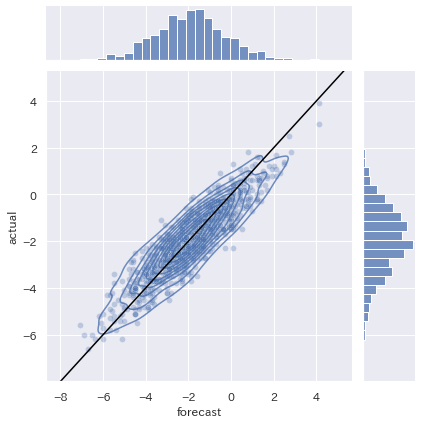

In [10]:
# 予測値と実測値の散布図＋カーネル密度推定
g = sns.jointplot(x = a_f.forecast, y = a_f.actual, alpha = 0.3).plot_joint(sns.kdeplot, alpha = 0.8)

# 傾き1の直線
#plt.plot([-7, 4], [-7, 4], color = "black")
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r', color = "black")

## 3.6.3 予測値と実測値の分割表

In [11]:
# 階級を分けるためのbin
bins = np.arange(-7.5, 5, 1)
bins

array([-7.5, -6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,
        3.5,  4.5])

In [15]:
# 各階級に属するデータの度数分布
hist = np.histogram2d(a_f.actual, a_f.forecast, bins = bins)
np.set_printoptions(linewidth = 70)
print(hist[0])

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  2.   5.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   6.  12.  16.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   3.  16.  45.  21.   5.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   7.  42.  89.  54.   3.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   6.  74. 124.  55.   4.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   4.  62. 110.  61.   4.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.  36.  54.  24.   2.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   9.  19.  11.   2.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   3.   1.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]]


In [22]:
# 相対度数分布
norm_hist = hist[0] / sum(sum(hist[0]))
joint_forecast_state = pd.DataFrame(norm_hist)
joint_forecast_state.columns = np.char.add(index_name, "予測")
joint_forecast_state.index = index_name
joint_forecast_state

,-7度予測,-6度予測,-5度予測,-4度予測,-3度予測,-2度予測,-1度予測,0度予測,1度予測,2度予測,3度予測,4度予測
-7度,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
-6度,0.002,0.005,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
-5度,0.000,0.006,0.012,0.016,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
-4度,0.000,0.003,0.016,0.045,0.021,0.005,0.000,0.000,0.000,0.000,0.000,0.000
-3度,0.000,0.000,0.007,0.042,0.089,0.054,0.003,0.000,0.000,0.000,0.000,0.000
-2度,0.000,0.000,0.000,0.006,0.074,0.124,0.055,0.004,0.000,0.000,0.000,0.000
-1度,0.000,0.000,0.000,0.000,0.004,0.062,0.110,0.061,0.004,0.000,0.000,0.000
0度,0.000,0.000,0.000,0.000,0.000,0.002,0.036,0.054,0.024,0.002,0.000,0.000
1度,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.009,0.019,0.011,0.002,0.000
2度,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.001,0.001,0.000


## 3.6.4 ヒートマップによる分割表の可視化

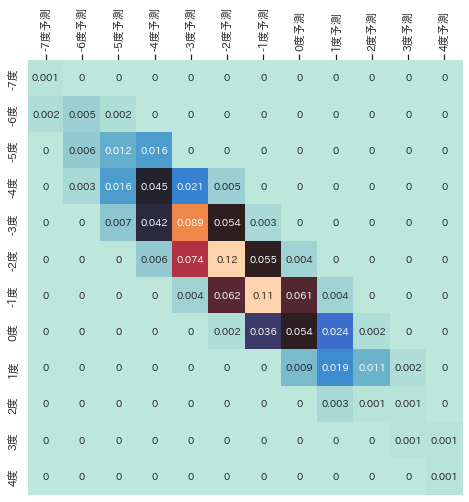

In [24]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.xaxis.set_ticks_position("top")
sns.heatmap(joint_forecast_state, annot = True, cbar = False, square = True, vmax = 0.1, vmin = 0, center = 0.05, ax = ax)

# 3.8 予測の価値評価の準備

In [25]:
# 最大値をとるインデックスを取得する関数
def argmax_list(series):
  return list(series[series == series.max()].index)

In [26]:
# 期待金額最大化に基づく意思決定を行う関数
def max_emv(probs, payoff_table):
  emv = payoff_table.mul(probs, axis = 0).sum()
  max_emv = emv.max()
  a_star = argmax_list(emv)
  return pd.Series([a_star, max_emv], index = ["選択肢", "期待金額"])

In [27]:
# 予測および自然の状態の周辺分布
marginal_forecast = joint_forecast_state.sum(axis = 0)
marginal_state = joint_forecast_state.sum(axis = 1)

In [28]:
# 自然の状態の，予測に対する条件付き分布
conditional_forecast = joint_forecast_state.div(marginal_forecast, axis = 1)

# 3.9 予測を使わないときの期待金額

In [29]:
naive_decision = max_emv(marginal_state, payoff)
naive_decision

選択肢      [対策あり]
期待金額       177.067
dtype: object

In [39]:
emv_naive = naive_decision["期待金額"]
print(f"予測を使わないときの期待金額：{emv_naive:.3g}万円")

予測を使わないときの期待金額：177万円


# 3.10 予測を使うときの期待金額

In [34]:
# 予測が与えられたときの，期待金額を最大にする選択肢とそのときの期待金額
info_decision = conditional_forecast.apply(max_emv, axis = 0, payoff_table = payoff)
info_decision

,-7度予測,-6度予測,-5度予測,-4度予測,-3度予測,-2度予測,-1度予測,0度予測,1度予測,2度予測,3度予測,4度予測
選択肢,[対策あり],[対策あり],[対策あり],[対策あり],[対策あり],[対策あり],[対策なし],[対策なし],[対策なし],[対策なし],[対策なし],[対策なし]
期待金額,22.099,110.297,158.369,173.731,180.0,180.0,186.368,198.665,200.0,200.0,200.0,200.0


In [37]:
# 予測の周辺分布で期待値をとる
emv_forecast = info_decision.loc["期待金額"].mul(marginal_forecast).sum()
print(f"予測を使ったときの期待金額：{emv_forecast:.3g}万円")

予測を使ったときの期待金額：182万円


In [41]:
# 同時分布を使って計算しても同じ結果を得る
emv_forecast_joint = joint_forecast_state.apply(max_emv, axis = 0, payoff_table = payoff).loc["期待金額"].sum()
print(f"同時分布から計算された期待金額：{emv_forecast_joint:.3g}万円")

同時分布から計算された期待金額：182万円


# 3.11 予測の価値

In [42]:
f_value = emv_forecast - emv_naive
print(f"予測の価値：{f_value:.3g}万円")

予測の価値：5.09万円


# 3.12 予測に忠実に従うときの期待金額

In [44]:
# 気温ごとの利得が最大になる選択肢一覧
payoff.idxmax(axis = 1)

-7度    対策なし
-6度    対策あり
-5度    対策あり
-4度    対策あり
-3度    対策あり
-2度    対策あり
-1度    対策なし
0度     対策なし
1度     対策なし
2度     対策なし
3度     対策なし
4度     対策なし
dtype: object

In [46]:
# 予測を完全に信じたときの利得行列
payoff_naive_f = payoff[payoff.idxmax(axis = 1)]
payoff_naive_f

,対策なし,対策あり,対策あり,対策あり,対策あり,対策あり,対策なし,対策なし,対策なし,対策なし,対策なし,対策なし
-7度,0.163,-5.870,-5.870,-5.870,-5.870,-5.870,0.163,0.163,0.163,0.163,0.163,0.163
-6度,0.728,36.083,36.083,36.083,36.083,36.083,0.728,0.728,0.728,0.728,0.728,0.728
-5度,3.243,137.290,137.290,137.290,137.290,137.290,3.243,3.243,3.243,3.243,3.243,3.243
-4度,14.130,180.000,180.000,180.000,180.000,180.000,14.130,14.130,14.130,14.130,14.130,14.130
-3度,56.083,180.000,180.000,180.000,180.000,180.000,56.083,56.083,56.083,56.083,56.083,56.083
-2度,157.290,180.000,180.000,180.000,180.000,180.000,157.290,157.290,157.290,157.290,157.290,157.290
-1度,200.000,180.000,180.000,180.000,180.000,180.000,200.000,200.000,200.000,200.000,200.000,200.000
0度,200.000,180.000,180.000,180.000,180.000,180.000,200.000,200.000,200.000,200.000,200.000,200.000
1度,200.000,180.000,180.000,180.000,180.000,180.000,200.000,200.000,200.000,200.000,200.000,200.000
2度,200.000,180.000,180.000,180.000,180.000,180.000,200.000,200.000,200.000,200.000,200.000,200.000


In [47]:
# 予測に忠実に従ったときの期待金額
weighted_payoff_naive = joint_forecast_state.values * payoff_naive_f.values
emv_naive_f = sum(sum(weighted_payoff_naive))

# 予測の価値
naive_f_value = emv_naive_f - emv_naive
print(f"予測の価値：{naive_f_value:.3g}万円")

予測の価値：5.02万円


# 3.13 完全情報の価値

In [48]:
# 自然の状態別の最大利得
payoff.max(axis = 1)

-7度      0.163
-6度     36.083
-5度    137.290
-4度    180.000
-3度    180.000
-2度    180.000
-1度    200.000
0度     200.000
1度     200.000
2度     200.000
3度     200.000
4度     200.000
dtype: float64

In [49]:
# 自然の状態に合わせて利得を最大にする行動をとったときの期待金額
emv_perfect = payoff.max(axis = 1).mul(marginal_state).sum()

# 完全情報の価値
perfect_information_value = emv_perfect - emv_naive
print(f"完全情報の価値：{perfect_information_value:.3g}万円")

完全情報の価値：8.17万円


# 3.14 予測の有効性

In [50]:
efficiency = f_value / perfect_information_value
print(f"予測の有効性：{efficiency:.3g}")

予測の有効性：0.623
